# Explore K562 LentiMPRA Activity for Library Design
Load K562 data, inspect folds, and visualize activity distributions to decide on bin cutoffs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load K562 data (forward strand only, matching training pipeline)
data_path = "/grid/wsbs/home_norepl/pmantill/LentiMPRA_mcs/LentiMoCon/test_run_lenti_data/K562.tsv"
df = pd.read_csv(data_path, sep="\t")
df = df[df["rev"] == 0].copy()
print(f"Total sequences (fwd only): {len(df)}")
df.head(10)

Total sequences (fwd only): 196664


,seq_id,seq,mean_value,fold,rev
0,peak10,AGGACCGGATCAACTTGTCGCCTTAATCCAAGCCTACGTTTTTACA...,-0.490,8,0
1,peak10_Reversed:,AGGACCGGATCAACTAGTATGAGGAGGGTTGTGGAGTGGAAGTGAA...,-0.131,8,0
2,peak1000,AGGACCGGATCAACTCATCTACATAGAAGTCGCCCTGTCCGTGATG...,0.628,6,0
3,peak1000_Reversed:,AGGACCGGATCAACTTTGCTCCTTAACACAGGCTAAGGACCAGCTT...,1.263,6,0
4,peak10000,AGGACCGGATCAACTATGGCAGCAGCAGCCCGTCTAGGGTGGCCAC...,-0.131,3,0
5,peak10000_Reversed:,AGGACCGGATCAACTTCCTGGCCCCCAAGAGCACAGGGAGGCCTTG...,-0.040,3,0
6,peak10001,AGGACCGGATCAACTTAGTAGAGACGGGGTTTCTCCATGTTGGTCA...,-0.804,7,0
7,peak10001_Reversed:,AGGACCGGATCAACTTTTTAGACTGTGCAGTTAAGTAAGGCCTCAC...,-0.527,7,0
8,peak10002,AGGACCGGATCAACTACACTGCCAGAGCTGCTCTGCACTGCGAGTC...,-0.331,4,0
9,peak10002_Reversed:,AGGACCGGATCAACTTCCACCGCGCTTCCTCCACGAAACCACACAG...,0.304,4,0


In [3]:
# Sequences per fold
fold_counts = df["fold"].value_counts().sort_index()
print("Sequences per fold:")
print(fold_counts)
print(f"\nTest fold (10): {fold_counts.get(10, 0)} seqs")
print(f"Val fold (1):   {fold_counts.get(1, 0)} seqs")
print(f"Train folds (2-9): {fold_counts.loc[2:9].sum()} seqs")

Sequences per fold:
fold
1     19666
2     19666
3     19666
4     19666
5     19666
6     19666
7     19666
8     19666
9     19666
10    19670
Name: count, dtype: int64

Test fold (10): 19670 seqs
Val fold (1):   19666 seqs
Train folds (2-9): 157328 seqs


In [4]:
# Basic activity stats
print("Activity (mean_value) summary:")
print(df["mean_value"].describe())
print(f"\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {df['mean_value'].quantile(p/100):.4f}")

Activity (mean_value) summary:
count    196664.000000
mean         -0.097936
std           0.526051
min          -2.135000
25%          -0.466000
50%          -0.203000
75%           0.182000
max           3.427000
Name: mean_value, dtype: float64

Percentiles:
  1th: -1.0400
  5th: -0.7790
  10th: -0.6620
  25th: -0.4660
  50th: -0.2030
  75th: 0.1820
  90th: 0.6810
  95th: 0.9510
  99th: 1.3534


In [5]:
# Activity stats per fold
print("Activity stats per fold:")
print(df.groupby("fold")["mean_value"].describe().round(3))

Activity stats per fold:
        count   mean    std    min    25%    50%    75%    max
fold                                                          
1     19666.0 -0.095  0.526 -1.854 -0.462 -0.202  0.186  2.899
2     19666.0 -0.097  0.533 -1.750 -0.470 -0.202  0.184  3.427
3     19666.0 -0.104  0.524 -1.692 -0.470 -0.211  0.173  2.670
4     19666.0 -0.096  0.525 -2.030 -0.466 -0.202  0.182  2.880
5     19666.0 -0.098  0.524 -1.747 -0.463 -0.200  0.180  3.273
6     19666.0 -0.105  0.524 -1.643 -0.469 -0.209  0.173  2.748
7     19666.0 -0.092  0.526 -1.774 -0.465 -0.196  0.192  2.597
8     19666.0 -0.095  0.523 -2.135 -0.459 -0.206  0.186  2.101
9     19666.0 -0.094  0.530 -1.722 -0.465 -0.199  0.184  3.270
10    19670.0 -0.103  0.526 -1.602 -0.472 -0.206  0.179  2.838


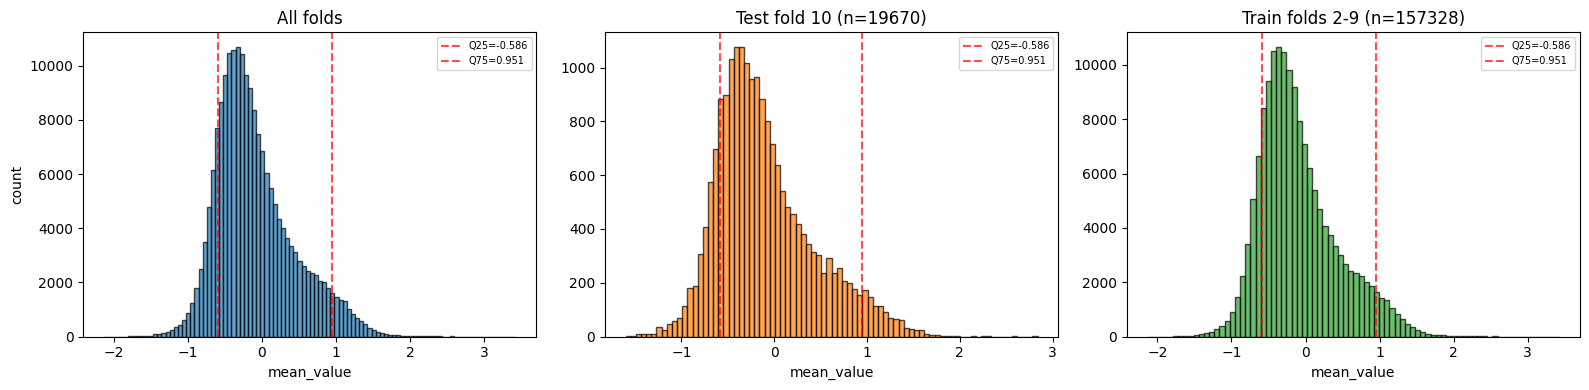

In [6]:
# Histogram of activity — all data
q25 = df["mean_value"].quantile(0.15)
q75 = df["mean_value"].quantile(0.95)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax in axes:
    ax.axvline(q25, color="red", linestyle="--", alpha=0.7, label=f"Q25={q25:.3f}")
    ax.axvline(q75, color="red", linestyle="--", alpha=0.7, label=f"Q75={q75:.3f}")

axes[0].hist(df["mean_value"], bins=100, edgecolor="k", alpha=0.7)
axes[0].set_xlabel("mean_value")
axes[0].set_ylabel("count")
axes[0].set_title("All folds")
axes[0].legend(fontsize=7)

# Test fold (10) — 70% of library
test_df = df[df["fold"] == 10]
axes[1].hist(test_df["mean_value"], bins=80, edgecolor="k", alpha=0.7, color="C1")
axes[1].set_xlabel("mean_value")
axes[1].set_title(f"Test fold 10 (n={len(test_df)})")
axes[1].legend(fontsize=7)

# Train folds (2-9) — 30% of library
train_df = df[df["fold"].isin(range(2, 10))]
axes[2].hist(train_df["mean_value"], bins=80, edgecolor="k", alpha=0.7, color="C2")
axes[2].set_xlabel("mean_value")
axes[2].set_title(f"Train folds 2-9 (n={len(train_df)})")
axes[2].legend(fontsize=7)

plt.tight_layout()
plt.show()

Predictions loaded: 19670 samples
Pearson r = 0.8753


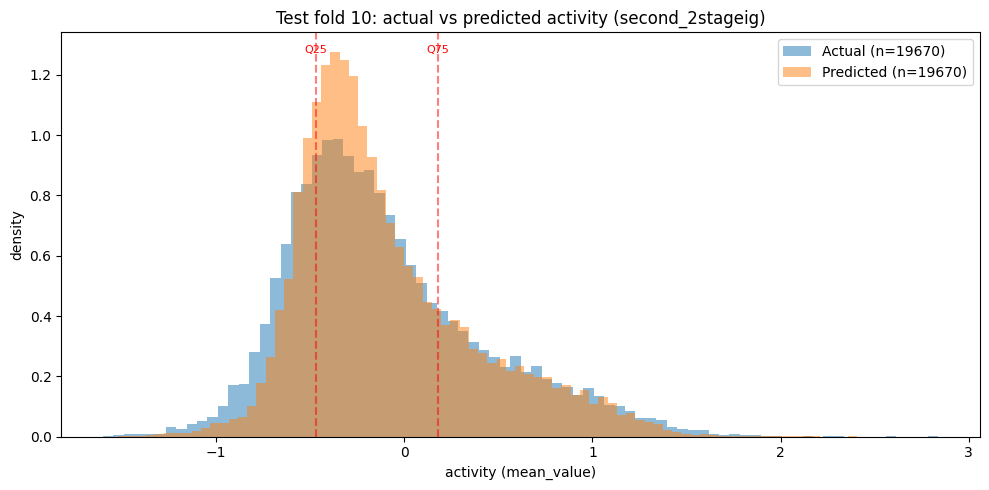

In [7]:
# Load model predictions on test fold
pred_path = "/grid/wsbs/home_norepl/pmantill/LentiMPRA_mcs/LentiMoCon/lenti_AGFT/training/results/second_2stageig/test_predictions.npz"
preds = np.load(pred_path)
pred_targets = preds["targets"]
pred_predictions = preds["predictions"]
print(f"Predictions loaded: {len(pred_predictions)} samples")
from scipy.stats import pearsonr
r, _ = pearsonr(pred_targets, pred_predictions)
print(f"Pearson r = {r:.4f}")

# Overlaid histograms: actual vs predicted activity (test fold)
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(pred_targets, bins=80, alpha=0.5, label=f"Actual (n={len(pred_targets)})", density=True)
ax.hist(pred_predictions, bins=80, alpha=0.5, label=f"Predicted (n={len(pred_predictions)})", density=True)
ax.set_xlabel("activity (mean_value)")
ax.set_ylabel("density")
ax.set_title("Test fold 10: actual vs predicted activity (second_2stageig)")
ax.legend()

# Quartile lines from actual
for q in [0.25, 0.75]:
    val = np.quantile(pred_targets, q)
    ax.axvline(val, color="red", linestyle="--", alpha=0.5)
    ax.text(val, ax.get_ylim()[1]*0.95, f"Q{int(q*100)}", ha="center", fontsize=8, color="red")

plt.tight_layout()
plt.show()

In [8]:
# Candidate bin counts at different cutoffs
print("Candidate activity bins (all fwd seqs):")
print("="*50)
cutoffs = [-1.5, -0.5, 0.0, 0.25, 0.5, 0.75, 1.5]
bins_edges = [-np.inf] + cutoffs + [np.inf]
labels = [f"({bins_edges[i]:.2f}, {bins_edges[i+1]:.2f}]" for i in range(len(bins_edges)-1)]
df["activity_bin"] = pd.cut(df["mean_value"], bins=bins_edges, labels=labels)
print(df["activity_bin"].value_counts().sort_index())
print(f"\nSame for test fold only:")
print(df[df['fold']==10]["activity_bin"].value_counts().sort_index())

Candidate activity bins (all fwd seqs):
activity_bin
(-inf, -1.50]        64
(-1.50, -0.50]    43136
(-0.50, 0.00]     85507
(0.00, 0.25]      24436
(0.25, 0.50]      15665
(0.50, 0.75]      11029
(0.75, 1.50]      15883
(1.50, inf]         944
Name: count, dtype: int64

Same for test fold only:
activity_bin
(-inf, -1.50]        6
(-1.50, -0.50]    4415
(-0.50, 0.00]     8521
(0.00, 0.25]      2387
(0.25, 0.50]      1556
(0.50, 0.75]      1146
(0.75, 1.50]      1548
(1.50, inf]         91
Name: count, dtype: int64
